# Modeling

In [2]:
# imports
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import os
import time
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
plt.style.use('dark_background')

In [3]:
# read in data using pandas
df = pd.read_csv('../data/data_cleaned.csv')

In [4]:
# Joining all documents in corpus into a single document.
lyrics = '\n'.join([i for i in df['lyrics']])

In [5]:
# all unique characters
vocab = sorted(set(lyrics))
len(vocab)

133

#### StringLookup from Tensorflow's library creates a library of unique characters.

In [6]:
# creating a dictionary of unique characters
ids_from_chars = preprocessing.StringLookup(
    vocabulary=list(vocab))

In [7]:
ids_from_chars

#### The reverse of string look up, get_vocabulary() gets unique character associated with the ID and reverses the above function.

In [8]:
# reverse lookup of unique characters from ID's
chars_from_ids = preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True)

In [9]:
chars_from_ids

#### Piece by piece what is happening under the hood.

In [10]:
# Example
example = ['hola', 'papi']
example = tf.strings.unicode_split(example, input_encoding='UTF-8') # splits string into list via tf library 
print(example)
example = ids_from_chars(example)
print(example)

<tf.RaggedTensor [[b'h', b'o', b'l', b'a'], [b'p', b'a', b'p', b'i']]>
<tf.RaggedTensor [[70, 77, 74, 63], [78, 63, 78, 71]]>


In [11]:
example = chars_from_ids(example)
print(example)

<tf.RaggedTensor [[b'h', b'o', b'l', b'a'], [b'p', b'a', b'p', b'i']]>


#### Reduce_join() is a str function in the tensorflow library. Joins the list of strings together.

In [12]:
example = tf.strings.reduce_join(example, axis=-1) # joins strings back
print(example)

tf.Tensor([b'hola' b'papi'], shape=(2,), dtype=string)


In [13]:
def textFromIds(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [14]:
# Preparing dataset for modeling.
idsFromLyrics = tf.strings.unicode_split(lyrics, input_encoding='UTF-8')
idsFromLyrics = ids_from_chars(idsFromLyrics)

#### Joining the input data sequentially into a data frame in tensor slices

In [15]:
# Appending to tf.data.Dataset via tf.data.Dataset.from_tensor_slices which creates a sequential dataset. 
data = tf.data.Dataset.from_tensor_slices(idsFromLyrics)

In [16]:
# Snippet from the dataset.
for i in data.take(7):
    print(chars_from_ids(i).numpy().decode('UTF-8'))

H
e
r
 
d
a
y


#### .batch() breaks the dataset into batches in sequences of 80 characters. 

In [17]:
# Batch lets you split the dataset into desired lengths.
seq_length = 80
data = data.batch(seq_length+1, drop_remainder=True) #drop_remainder drops the last batch

In [18]:
# Snippet from revamped dataset.
for i in data.take(2):
    print(textFromIds(i).numpy())

b'Her day starts with a coffee and ends with a wine\nTakes forever getting ready so '
b'she\'s never on time for anything\nWhen she gets that "come get me" look in her eye'


#### In order for our model to be able to predict, it needs something to predict. In our case, we'll have our model train everything but the last character, and predict on everything else in the sequence but the first character!

In [19]:
# Splitting Target value and Input values.
def split_data(seq):
    inputText = seq[:-1]
    targetText = seq[1:]
    return inputText, targetText

In [20]:
# Map it over the dataset.
data = data.map(split_data)

In [21]:
# Example
print(split_data('Sequences'))

('Sequence', 'equences')


In [22]:
# Snippet
for input_, target_ in data.take(1):
    print(f'Target: ', textFromIds(target_).numpy())
    print(f'Input: ', textFromIds(input_).numpy())

Target:  b'er day starts with a coffee and ends with a wine\nTakes forever getting ready so '
Input:  b'Her day starts with a coffee and ends with a wine\nTakes forever getting ready so'


#### The input and target data live in the same variable, they're stuck together in pairs. We'll shuffle, rebatch, and add a .prefetch. .prefetch() allows for optimal training time. While one batch is training, the next batched is prepped and ready to train as soon as the training batch is done.

In [24]:
# Shuffling and packing the data into batches
batch_size = 64
buffer_size = 10_000 # Instead of trying to shuffle all the data in memory
                    # Adding a buffer_size keeps the TF data from shuffling all the sequences in memory
data = (data.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE))
                                                    # Prefetch fetches your next piece of input data and preps it before what's
                                                    # training is done.

#### Building our models via subclassing.

##### We'll build 2 models, compile models and pin them against eachother to see which have better signs of performance.

In [25]:
class rnn_model(keras.Model):
    def __init__(self, vocab_size, rnn_units, embedding_dim):
        super().__init__(self)
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim) # Embedding layer adds significance to indexes of text.
        self.lstm = keras.layers.LSTM(rnn_units, return_sequences=True, return_state=True) # RNN layer
        self.out = keras.layers.Dense(vocab_size) # output layer

    def call(self, inputs, states=None, training=False, return_state=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None: # initializing a state
            states = self.lstm.get_initial_state(x)
        x, states_h, states_c = self.lstm(x, initial_state=states, training=training) # making sure all 3 outputs are accounted for
        x = self.out(x, training=training)
        if return_state:
            return x, states # return states
        else:
            return x # else return model

In [26]:
# Directory where the checkpoints will be saved
checkpoint_dir = '../training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [27]:
#Build model 2 using subclassing
class rnn_model1(tf.keras.Model):
    def __init__(self, vocab_size, rnn_units, embedding_dim):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        self.out = tf.keras.layers.Dense(vocab_size)
        
    def call(self, inputs, states=None, training=False, return_state=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.out(x,training=training)
        
        if return_state:
            return x, states
        else:
            return x

In [27]:
# Directory where the checkpoints will be saved
checkpoint_dir = '../training_checkpoints1'
# Name of the checkpoint files
checkpoint_prefix1 = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix1,
    save_weights_only=True)

In [31]:
# Initialize the Model
model = rnn_model(len(
    ids_from_chars.get_vocabulary()),
                  rnn_units=1024,
                  embedding_dim=256)

In [32]:
# try another model
model1 = rnn_model1(len(
    ids_from_chars.get_vocabulary()),
                  rnn_units=1024,
                  embedding_dim=256)

In [33]:
# compile models
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #works great with datasets with a lot of 0's
             optimizer= keras.optimizers.Adam(learning_rate=.0005))

In [34]:
model1.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer= keras.optimizers.Adam(learning_rate=.0005))

In [32]:
#Fit your subclassed model
history = model.fit(data, epochs=5, callbacks=[checkpoint_callback])

Epoch 1/5
1391/1391 [==============================] - 1811s 1s/step - loss: 2.3631
Epoch 2/5
1391/1391 [==============================] - 1820s 1s/step - loss: 1.4453
Epoch 3/5
1391/1391 [==============================] - 1760s 1s/step - loss: 1.2924
Epoch 4/5
1391/1391 [==============================] - 1717s 1s/step - loss: 1.2211
Epoch 5/5
1391/1391 [==============================] - 1735s 1s/step - loss: 1.1738


In [33]:
model.summary()

Model: "rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  34560     
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
dense (Dense)                multiple                  138375    
Total params: 5,419,911
Trainable params: 5,419,911
Non-trainable params: 0
_________________________________________________________________


In [34]:
#Fit your subclassed model
history1 = model1.fit(data, epochs=5, callbacks=[checkpoint_callback1])

Epoch 1/5
1391/1391 [==============================] - 1420s 1s/step - loss: 2.3697
Epoch 2/5
1391/1391 [==============================] - 1427s 1s/step - loss: 1.3316
Epoch 3/5
1391/1391 [==============================] - 1392s 1000ms/step - loss: 1.2062
Epoch 4/5
1391/1391 [==============================] - 1301s 935ms/step - loss: 1.1409
Epoch 5/5
1391/1391 [==============================] - 1348s 968ms/step - loss: 1.0924


In [35]:
model1.summary()

Model: "rnn_model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  34560     
_________________________________________________________________
gru (GRU)                    multiple                  3938304   
_________________________________________________________________
dense_1 (Dense)              multiple                  138375    
Total params: 4,111,239
Trainable params: 4,111,239
Non-trainable params: 0
_________________________________________________________________


#### Without a validation test set, the loss is almost arbitrary, but the GRU model is performing constistently better at early epochs. Time to fully train one of the models.

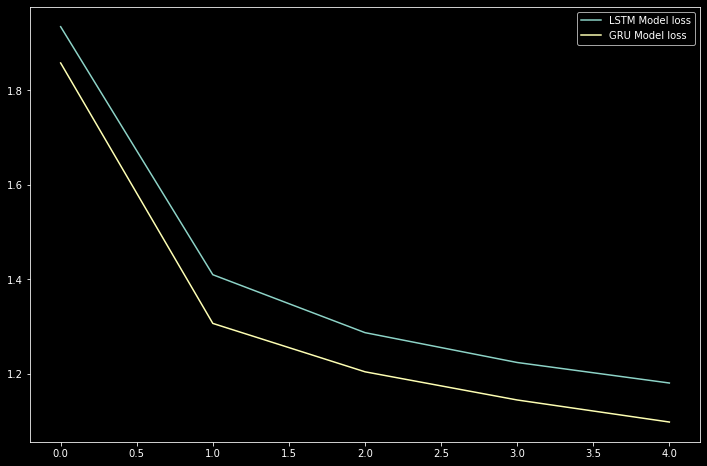

In [43]:
# plot model performance
model_loss = history.history['loss']
model1_loss = history1.history['loss']
plt.figure(figsize=(12, 8))
plt.plot(model_loss, label='LSTM Model loss')
plt.plot(model1_loss, label='GRU Model loss')
plt.legend();

In [37]:
# Directory where the checkpoints will be saved
checkpoint_dir = '../training_checkpoints2'
# Name of the checkpoint files
checkpoint_prefix2 = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix2,
    save_weights_only=True)

In [38]:
history2 = model1.fit(data, epochs=25, callbacks=[checkpoint_callback2])

Epoch 1/25
1391/1391 [==============================] - 1361s 978ms/step - loss: 1.0582
Epoch 2/25
1391/1391 [==============================] - 1365s 981ms/step - loss: 1.0221
Epoch 3/25
1391/1391 [==============================] - 1393s 1s/step - loss: 0.9896
Epoch 4/25
1391/1391 [==============================] - 1398s 1s/step - loss: 0.9605
Epoch 5/25
1391/1391 [==============================] - 1422s 1s/step - loss: 0.9344
Epoch 6/25
1391/1391 [==============================] - 1376s 988ms/step - loss: 0.9118
Epoch 7/25
1391/1391 [==============================] - 1314s 944ms/step - loss: 0.8918
Epoch 8/25
1391/1391 [==============================] - 1315s 944ms/step - loss: 0.8750
Epoch 9/25
1391/1391 [==============================] - 1312s 942ms/step - loss: 0.8605
Epoch 10/25
1391/1391 [==============================] - 1317s 947ms/step - loss: 0.8484
Epoch 11/25
1391/1391 [==============================] - 1466s 1s/step - loss: 0.8384
Epoch 12/25
1391/1391 [===================

In [39]:
model1.save('../models/model')

INFO:tensorflow:Assets written to: ./models/model/assets


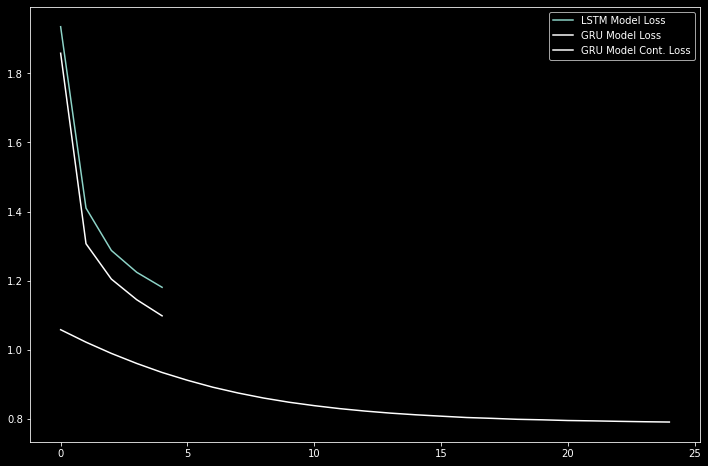

In [42]:
# plot model performance
model_loss = history.history['loss']
model1_loss = history1.history['loss']
model1_cont = history2.history['loss']
plt.figure(figsize=(12, 8))
plt.plot(model_loss, label='LSTM Model Loss')
plt.plot(model1_loss, label='GRU Model Loss', color='white')
plt.plot(model1_cont, label='GRU Model Cont. Loss', color='white')
plt.legend();

#### Extracting predictions from Model!

In [28]:
# from Tensorflow
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature=temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "" or "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['','[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices = skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())]) 
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits] 
    predicted_logits, states =  self.model(inputs=input_ids, states=states, 
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "" or "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model1, chars_from_ids, ids_from_chars)

In [ ]:
# from Tensorflow
start = time.time()
states = None
next_char = tf.constant(['Boots '])
result = [next_char]

for n in range(120):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()

print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)

print(f"\nRun time: {end - start}")